## Geospatial Data Processing Tools utilized
Geospatial analysis tools and Python packages:

- [**Google Earth Engine**](https://earthengine.google.com/) - a public data archive of petabytes of historical satellite imagery and geospatial datasets. In this tutorial, we will use the [Python Earth Engine API](https://developers.google.com/earth-engine/#api) to access Sentinel-2 RGB images. Note that you will need sign up for access to Google Earth Engine at https://code.earthengine.google.com/.
- [**GeoPandas**](https://geopandas.org/) - Extends the functionalities of pandas to add support for geographic data and geospatial analysis.
- [**Rasterio**](https://rasterio.readthedocs.io/en/latest/) - Raster data such as satellite images are often stored using the GeoTIFF format. Rasterio allows you to read and write these formats and perform advanced geospatial operations on these datasets.  
- [**Folium**](https://python-visualization.github.io/folium/) - Allows you to visualize geospatial data on an interactive leaflet map.

[comprehensive list of Python packages](https://github.com/giswqs/python-geospatial).

# Imports and Setup

In [ ]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert
!pip -q install eefolium

In [1]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json
import torch

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

### Authenticate Google Earth Engine
We need an access to Google Earth Engine at https://signup.earthengine.google.com/#!/. Once your request has been approved, you should be able to access Google Earth Engine at https://code.earthengine.google.com/.

In [2]:
ee.Authenticate()
ee.Initialize(project='luc-agricolo')

# Download Country Boundaries

Our first step is to download the administrative boundaries of our country of interest, which we will obtain via [geoBoundaries by the William and Mary GeoLab](https://www.geoboundaries.org/index.html). geoBoundaries is a free and openly accessible global database of political administrative boundaries for every country in the world. The geographic boundaries can be downloaded via API access through a simple query:

```
https://www.geoboundaries.org/api/current/[RELEASE-TYPE]/[3-LETTER-ISO-CODE]/[BOUNDARY-TYPE]/
```
- **RELEASE-TYPE** This is one of gbOpen, gbHumanitarian, or gbAuthoritative. gbOpen should be good
- **ISO** - The three-letter ISO code representing the country of interest.
- **ADM** - One of ADM0, ADM1, ADM2, ADM3, ADM4 or ADM5, representing each level of administrative hierarchy.

In this example, we choose **Italy** as our area of interest. We set the ISO code to "ITA" and ADM to "ADM2".
Save the result as a GeoJSON file, and read the file using GeoPandas.

In [5]:
ISO = 'ITA' # "ITA" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts

# Query geoBoundaries
r = requests.get(f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}/".format(ISO, ADM))

print('request', r.status_code) #Stato delle request
dl_path = r.json()['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

request 200


In [3]:
filename = 'Italia_geoboundary.geojson'
# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(20)

Data dimensions: (20, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
5,Friuli Venezia Giulia,,23120603B53770696546298,ITA,ADM2,"MULTIPOLYGON (((13.77538 45.61068, 13.77534 45..."
3,Trentino-Alto Adige,,23120603B10307341449000,ITA,ADM2,"POLYGON ((10.84015 45.83276, 10.84112 45.83243..."
8,Toscana,,23120603B95153686365028,ITA,ADM2,"MULTIPOLYGON (((11.10968 42.26361, 11.10937 42..."
13,Molise,,23120603B60242334488993,ITA,ADM2,"POLYGON ((13.97791 41.46249, 13.97901 41.46158..."
10,Marche,,23120603B49951072422318,ITA,ADM2,"POLYGON ((12.48740 43.89647, 12.48696 43.89645..."
7,Emilia-Romagna,,23120603B93883326437068,ITA,ADM2,"MULTIPOLYGON (((10.48069 44.18947, 10.48080 44..."
14,Campania,,23120603B14973764900567,ITA,ADM2,"MULTIPOLYGON (((15.29417 40.02414, 15.29421 40..."
4,Veneto,,23120603B96721879872173,ITA,ADM2,"POLYGON ((11.42674 44.95008, 11.42652 44.94963..."
17,Calabria,,23120603B55310757134450,ITA,ADM2,"MULTIPOLYGON (((15.80144 39.70044, 15.80130 39..."
2,Lombardia,,23120603B71310509030930,ITA,ADM2,"MULTIPOLYGON (((8.81669 45.02194, 8.81642 45.0..."


In this example, we visualize the adminstrative boundary for **Tuscany** using the GeoPandas `.plot()` function.

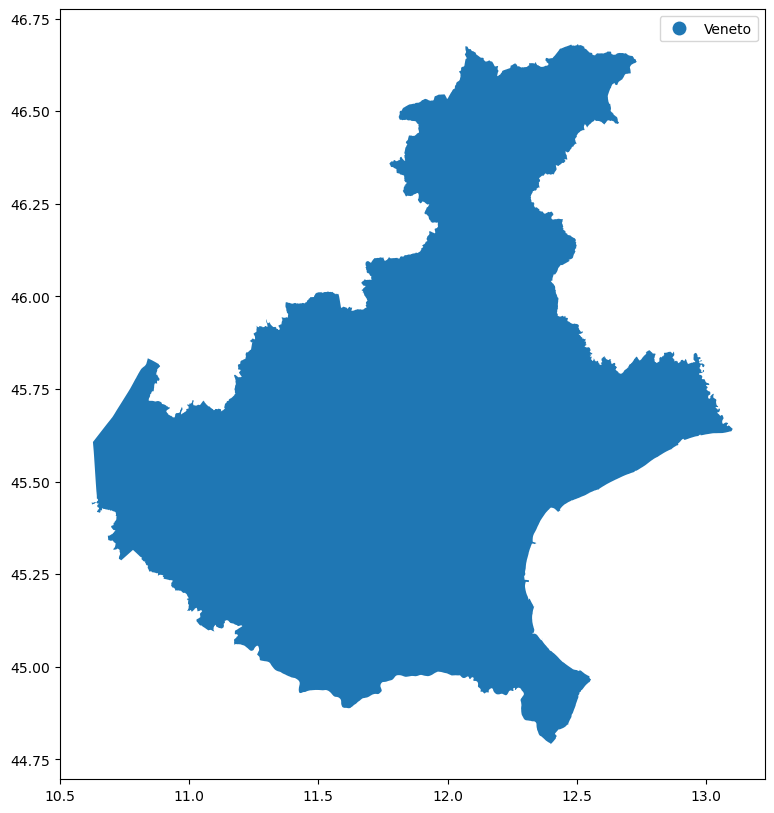

In [4]:
shape_name = 'Veneto'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

# Generate Sentinel-2 Satellite Images
Sentinel-2 is an Earth observation mission from the Copernicus Programme that provides global multispectral imagery every 10 days (2015 - present) at 10 m resolution (i.e. the length of one side of a pixel is equal to 10 meters).

Images are typically composed of 3 channels or bands: red, green, and blue. Sentinel-2, on the other hand, is able to capture 13 spectral bands:
- 4 bands at 10 meter: blue, green, red, and near-infrared
- 6 bands at 20 meter: for vegetation characterization and for applications such as snow/ice/cloud detection or vegetation moisture stress assessment.
- 3 bands at 60 meter: mainly for cloud screening and atmospheric corrections

For simplicity, we only used the Red, Green, and Blue bands for LULC classification. However, multispectral data contains rich information that can be useful for a number of applications including crop yield estimation, vegetation health monitoring, built-up area expansion analysis, informal settlement detection, and so much more. 

[Learn more about Sentinel-2 here](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects).


## Google Earth Engine
For simplicity, we downloaded Sentinel-2 RGB bands - red (B4), green (B3), and blue (B2).

In the following cell, we define a function to generate a Sentinel-2 image from Google Earth using the Python Earth Engine API. In order to minimize cloud cover, we chose to aggregate a collection of images over a period of time, as opposed to obtaining a single image on a given date.

In [24]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2005-01-01',
    max_date='2023-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

## Export Image to Local
In the following cell, we define a function to export our generated Sentinel-2 satellite image to our Google Drive.

We generate the Sentinel-2 satellite image for Tuscany. The satellite image is generated by getting the median of all Sentinel-2 images with a cloud cover of less than 10%.

We can now proceed to download the image to our local Google Drive as a GeoTIFF.

**Note**: Be careful about exporting large images as they can take a while to download and could eat up storage space!

In [5]:
# Get the shape geometry for Tuscany
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

In [25]:
# Generate RGB image using GEE
for i in range(2009, 2024, 2):
    Veneto = generate_image(
        region,
        product='COPERNICUS/S2', # Sentinel-2A
        min_date=f'{i}-01-01', # Get all images within range
        max_date=f'{i}-12-31', 
        cloud_pct=10, # Filter out images with cloud cover >= 10.0%
    )

    import os

    def export_image(image, filename, region, folder):
        """Export Image locally.

        Args:
        image (ee.image.Image): Generated Sentinel-2 image
        filename (str): Name of image, without the file extension
        region (ee.geometry.Geometry): The geometry of the area of
            interest to filter to.
        folder (str): The destination folder.

        Returns:
        str: Local path to the exported image
        """

        print('Exporting to {}.tif ...'.format(filename))

        # Define local path for saving the image
        local_path = os.path.join(folder, filename + '.tif')

        # Export image to local drive
        task = ee.batch.Export.image.toDrive(
        image=image,
        description=filename,
        folder=folder,
        region=region.geometry(),
        scale=10,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=900000000
        )
        task.start()

        # Wait for the task to complete
        while task.active():
            pass

        # Check if the task completed successfully
        if task.status()['state'] == 'COMPLETED':
            print('Image exported successfully to: {}'.format(local_path))
        else:
            print('Error exporting image. Task status:', task.status())

        return local_path
    
    folder = 'Veneto' # Change this to your file destination folder in Google drive
    filename = f"Veneto{i}"

    task = export_image(Veneto, filename, region, folder)

Exporting to Toscana2009.tif ...
Image exported successfully to: Toscana\Toscana2009.tif
Exporting to Toscana2011.tif ...
Image exported successfully to: Toscana\Toscana2011.tif
Exporting to Toscana2013.tif ...
Image exported successfully to: Toscana\Toscana2013.tif
Exporting to Toscana2015.tif ...
Image exported successfully to: Toscana\Toscana2015.tif
Exporting to Toscana2017.tif ...
Image exported successfully to: Toscana\Toscana2017.tif
Exporting to Toscana2019.tif ...
Image exported successfully to: Toscana\Toscana2019.tif
Exporting to Toscana2021.tif ...
Image exported successfully to: Toscana\Toscana2021.tif
Exporting to Toscana2023.tif ...
Image exported successfully to: Toscana\Toscana2023.tif


## Visualize Sentinel-2A Image

Once the task status changes to "COMPLETE", check that the satellite image is in your google drive. 

In the following cell, we load and visualize the satellite raster image using the Rasterio library.

# Generate 64x64 px GeoJSON Tiles

We trained a deep learning model on the [EuroSAT RGB dataset](), which consists of 64x64 pixel Sentinel-2 image patches. So we will break down our Sentinel-2 image into smaller 64x64 px tiles.

Let's start by creating a function that generates a grid of 64x64 px square polygons using rasterio

In [6]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the region Sentinel-2 satellite image.

In [7]:
for i in range(2016, 2024, 2):
    filename = f"Veneto/Veneto{i}"

    tif_file = '{}.tif'.format(filename) # Change this to your image file path
    # Open image file using Rasterio
    image = rio.open(tif_file)
    boundary = geoboundary[geoboundary.shapeName == shape_name]

    # Plot image and corresponding boundary
    # fig, ax = plt.subplots(figsize=(15,15))
    # boundary.plot(facecolor="none", edgecolor='red', ax=ax)
    # show(image, ax=ax);

    output_file = '{}.geojson'.format(filename)
    tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
    print('Data dimensions: {}'.format(tiles.shape))
    
    tiles = gpd.sjoin(tiles, boundary, op='within')

  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1183415087.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1183415087.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1183415087.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1183415087.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


## Visualize 64x64 px Tiles

Let's open the Sentinel-2 raster file using Rasterio and superimpose the 64x64px vector polygons as follows.

We set parameter `op='within'` to indicate that we only want the tiles that lie within the district boundary.


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_4060\2778194479.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


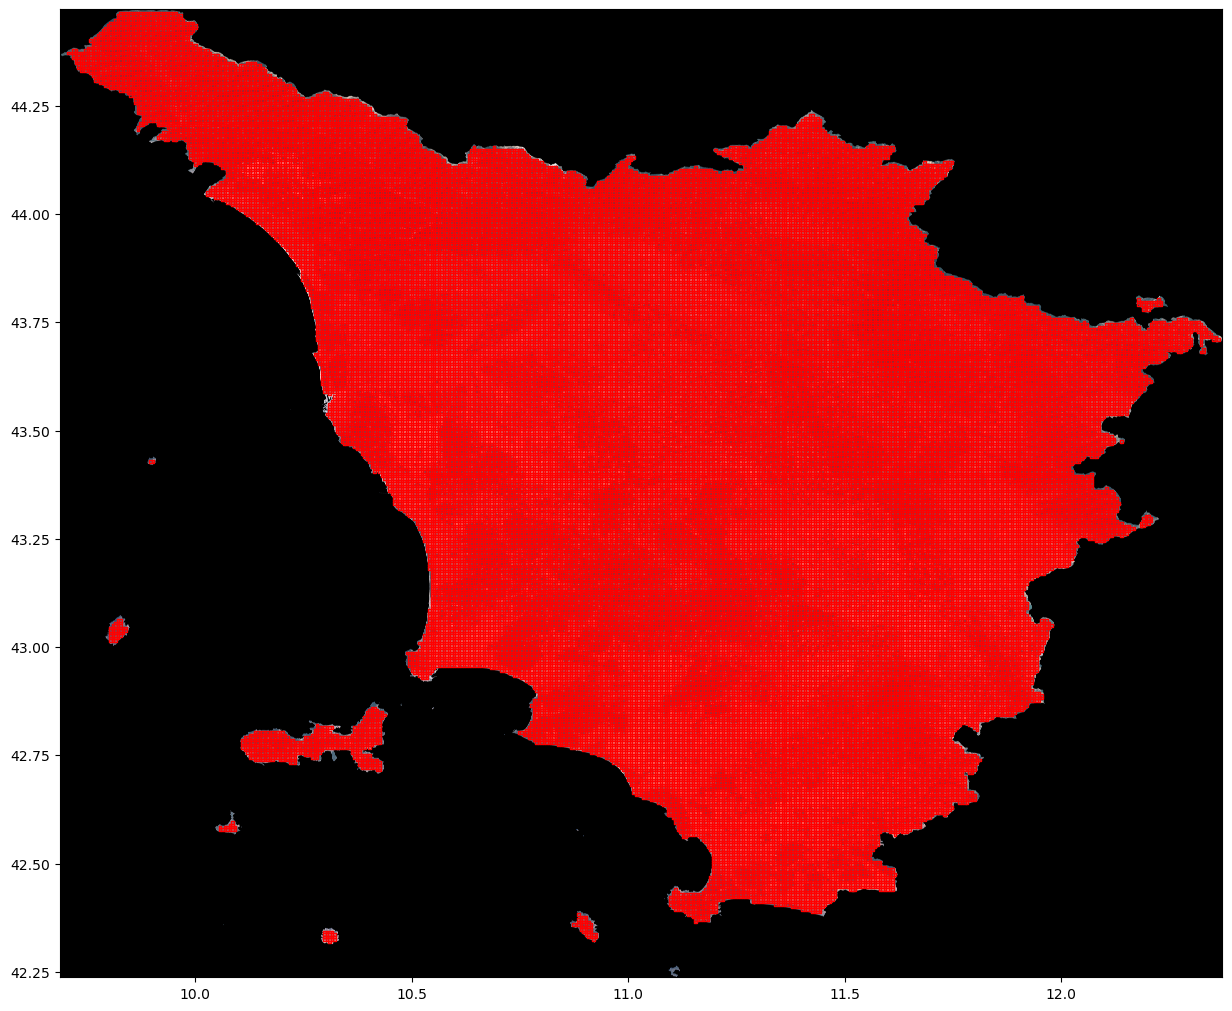

In [15]:
for i in range(2015, 2024, 2):
    filename = f"Toscana/Toscana{i}"

    tif_file = '{}.tif'.format(filename) # Change this to your image file path

    image = rio.open(tif_file)
    tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image
We can now crop our Sentinel-2 image using the generated grids.

Here, we visualize the Sentinel-2 image cropped using the first tile.

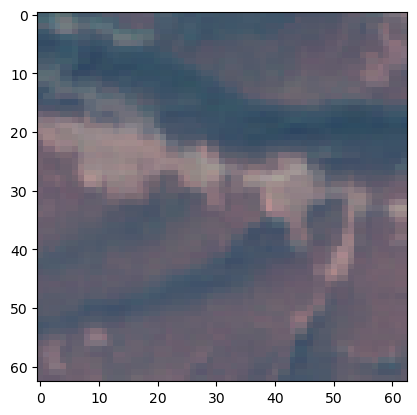

In [10]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

# Generate Land Use and Land Cover Map
In this section, we generated our land use and land cover classification map using the trained model from the previous tutorial. Recall that the EuroSAT dataset consists of 10 different LULC classes as listed below.

In [6]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Load Model trained on EuroSAT
First, we loaded the trained model.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = 'best_model.pth'

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model file best_model.pth successfully loaded.


We applied a set of data transformations to our test set before we run our new images through the model as follow.

In [8]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Model Prediction & LULC Map Generation

We defined a function that:
1. Crops the source image using the 64x64 tile geometry
2. Generates a prediction for the cropped image using the trained model

In [9]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rasterio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Open the cropped image and generate prediction
        # using the trained Pytorch model
        image_data = np.rollaxis(out_image, 0, 3)  # Change shape to (height, width, channels)
        image = Image.fromarray(image_data)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
            image.show(title=label)

        return label

    return None


The iteration over every 64x64 px tile generate the model predictions for the corresponding cropped image.

In [13]:
for i in range(2016, 2024, 2):
    filename = f"Veneto/Veneto{i}"

    tif_file = '{}.tif'.format(filename) # Change this to your image file path
    # Open image file using Rasterio
    image = rio.open(tif_file)
    boundary = geoboundary[geoboundary.shapeName == shape_name]

    # Plot image and corresponding boundary
    # fig, ax = plt.subplots(figsize=(15,15))
    # boundary.plot(facecolor="none", edgecolor='red', ax=ax)
    # show(image, ax=ax);

    output_file = '{}.geojson'.format(filename)
    tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
    print('Data dimensions: {}'.format(tiles.shape))
    
    tiles = gpd.sjoin(tiles, boundary, op='within')

    # Commence model prediction
    labels = [] # Store predictions
    for index in tqdm(range(len(tiles)), total=len(tiles)):
      label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
      labels.append(label)
    tiles['pred'] = labels
    
    # Save predictions
    filepath = "{}_preds.geojson".format(filename)
    tiles.to_file(filepath, driver="GeoJSON")

    tiles.head(3)

  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1952067948.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/62738 [00:00<?, ?it/s]

  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1952067948.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/62738 [00:00<?, ?it/s]

  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1952067948.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/62738 [00:00<?, ?it/s]

  0%|          | 0/580648800 [00:00<?, ?it/s]

c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (142128, 2)


c:\Users\anto_\anaconda3\envs\env_master\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\anto_\AppData\Local\Temp\ipykernel_14732\1952067948.py:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, op='within')


  0%|          | 0/62738 [00:00<?, ?it/s]

## Visualize Interactive LULC Map
Now we can generate an interactive LULC map using Folium.

In [10]:
for i in range(2015, 2024, 1):
  filename = f"Veneto/Veneto{i}"
  filepath = "{}_preds.geojson".format(filename)
  tiles = gpd.read_file(filepath)
  tiles.head(3)

  # We map each class to a corresponding color
  colors = {
    'AnnualCrop' : 'lightgreen',
    'Forest' : 'forestgreen',
    'HerbaceousVegetation' : 'yellowgreen',
    'Highway' : 'gray',
    'Industrial' : 'red',
    'Pasture' : 'mediumseagreen',
    'PermanentCrop' : 'chartreuse',
    'Residential' : 'magenta',
    'River' : 'dodgerblue',
    'SeaLake' : 'blue'
  }
  tiles['color'] = tiles["pred"].apply(
    lambda x: cl.to_hex(colors.get(x))
  )
  tiles.head(2)

  # Instantiate map centered on the centroid
  map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

  # Add Google Satellite basemap
  folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
  ).add_to(map)

  # Add LULC Map with legend
  legend_txt = '<span style="color: {col};">{txt}</span>'
  for label, color in colors.items():

    # Specify the legend color
    name = legend_txt.format(txt=label, col=color)
    feat_group = folium.FeatureGroup(name=name)

    # Add GeoJSON to feature group
    subtiles = tiles[tiles.pred==label]
    if len(subtiles) > 0:
      folium.GeoJson(
          subtiles,
          style_function=lambda feature: {
            'fillColor': feature['properties']['color'],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
          },
          name='LULC Map'
      ).add_to(feat_group)
      map.add_child(feat_group)

  folium.LayerControl().add_to(map)

  # Save the map to an HTML file
  map.save(f'{filename}_Map.html')

In [7]:
# Lista per memorizzare i dizionari per ogni anno
data_dicts = []

# Leggi i file geojson per ciascun anno e crea i dizionari di conteggio
for i in range(2015, 2024):
    filename = f'Veneto/Veneto{i}_preds.geojson'
    
    # Leggi il geojson
    df = pd.read_json(filename)
    
    # Inizializza il contatore per i valori di 'pred'
    pred_counts = {}
    
    # Itera attraverso le righe del DataFrame
    for index, row in df.iterrows():
        # Accedi alle proprietà della feature
        properties = row['features']['properties']
        # Ottieni il valore di 'pred'
        pred_value = properties.get('pred', None)
        # Se 'pred' è presente, aggiungi 1 al contatore corrispondente
        if pred_value:
            pred_counts[pred_value] = pred_counts.get(pred_value, 0) + 1
    
    # Salva il dizionario di conteggio
    data_dicts.append(pred_counts)

# Crea una lista di dataframe, uno per ogni anno
dfs = []
for i, data in enumerate(data_dicts):
    year = 2015 + i
    df = pd.DataFrame(list(data.items()), columns=['pred', f'count_{year}'])
    dfs.append(df)

# Unire tutti i dataframe in un unico dataframe finale
df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.merge(df, on='pred', how='outer').fillna(0)

# Assicurati che i conteggi siano di tipo intero
df_final.iloc[:, 1:] = df_final.iloc[:, 1:].astype(int)

df_final

,pred,count_2015,count_2016,count_2017,count_2018,count_2019,count_2020,count_2021,count_2022,count_2023
0,Pasture,6383,8060,7771,10701,8211,8245,6150,3311,1666.0
1,Industrial,5636,9030,10211,9808,11693,9329,14207,13892,40700.0
2,SeaLake,4989,3898,5242,3909,4519,3911,3782,3565,5883.0
3,HerbaceousVegetation,870,1219,1249,2887,4388,3375,4181,6289,1.0
4,PermanentCrop,23214,15797,16615,15420,15791,16222,17266,17850,18.0
5,Forest,8605,9203,7361,3502,2141,5648,1226,1729,0.0
6,Residential,2692,3931,3596,3639,4113,3709,4118,4493,2.0
7,River,4251,5499,5809,7123,6195,6134,5490,5801,16.0
8,AnnualCrop,5509,5295,4246,5038,5091,5533,5606,5037,14293.0
9,Highway,589,806,638,711,596,632,712,771,159.0


In [8]:
# Salva il dataframe come CSV
df_final.to_csv('Veneto_counts.csv')

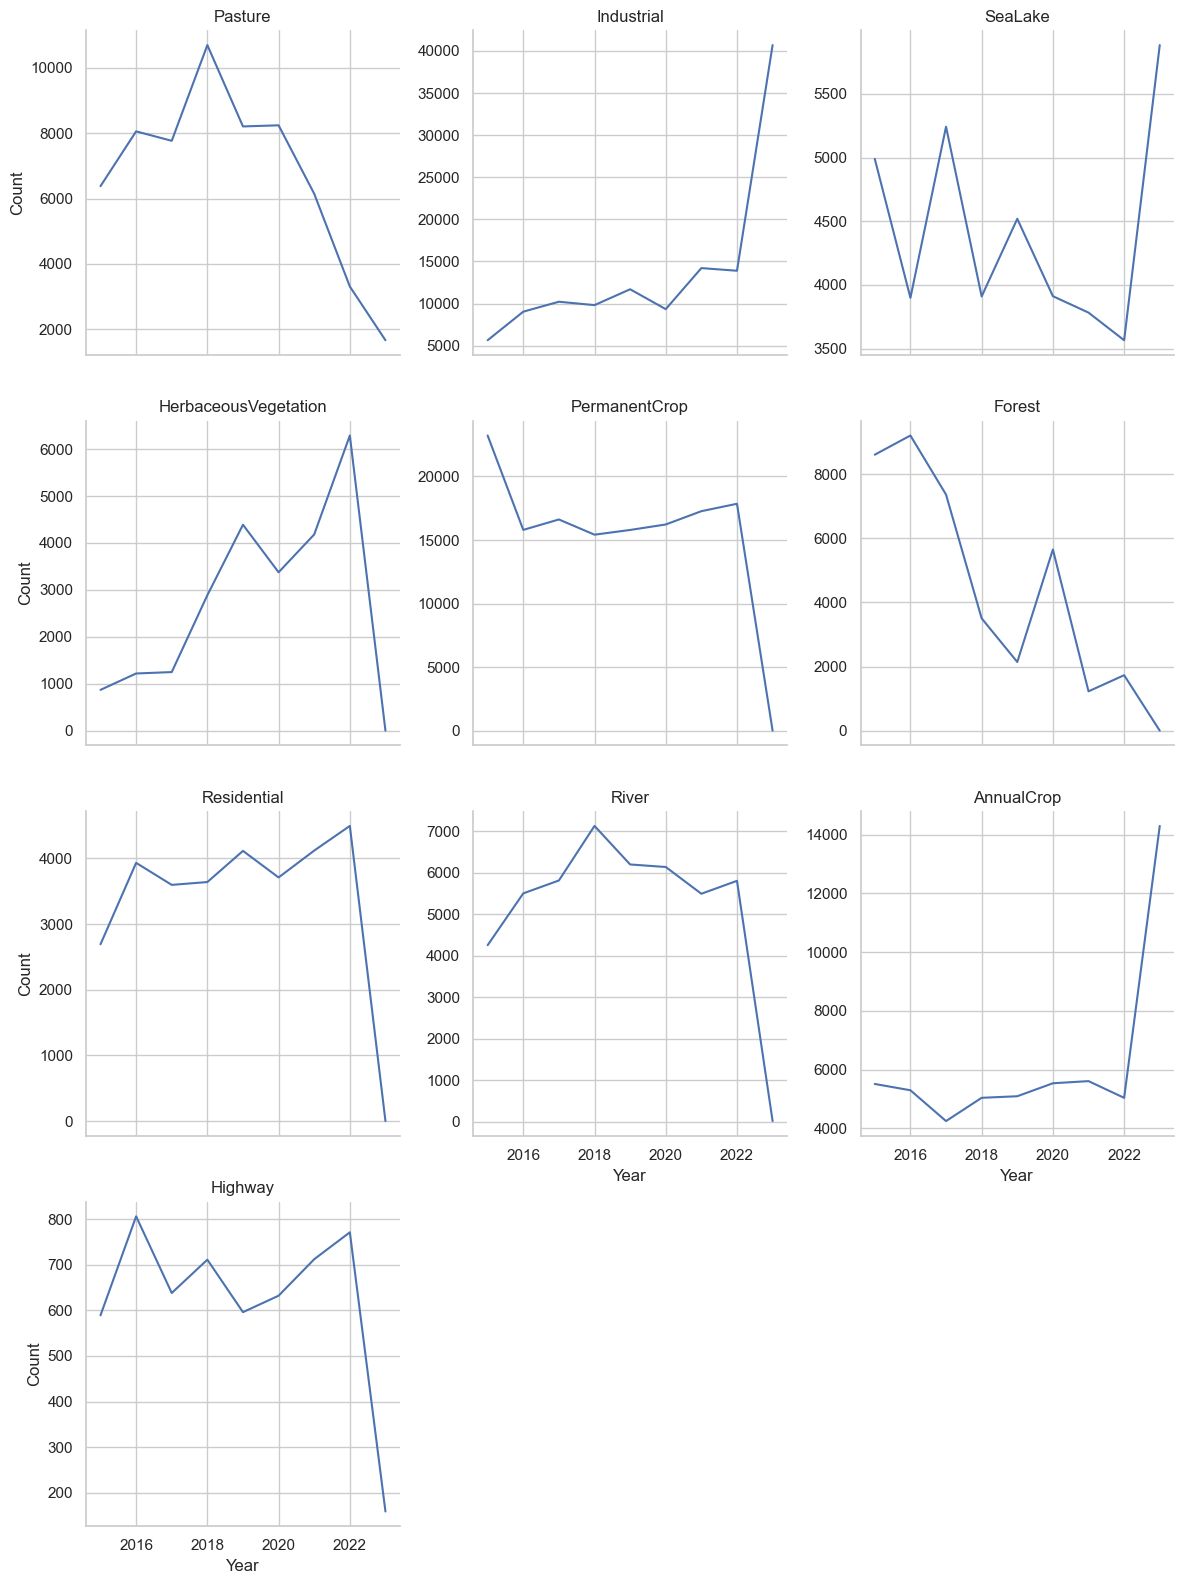

In [9]:
import seaborn as sns

# Trasforma il dataframe in formato lungo
df_long = pd.melt(df_final, id_vars=['pred'], var_name='year', value_name='count')

# Estrai l'anno dalla stringa
df_long['year'] = df_long['year'].str.extract('(\d{4})').astype(int)

# Imposta lo stile di Seaborn
sns.set(style="whitegrid")

# Crea una figura con subplot per ogni categoria
g = sns.FacetGrid(df_long, col='pred', col_wrap=3, sharey=False, height=4)
g.map(sns.lineplot, 'year', 'count')

# Aggiungi i titoli e regola i layout
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Count")
g.fig.tight_layout()

# Mostra i grafici
plt.show()

Generating a dictionary counter for the 10 different LULC classes for each year

# Conclusion
We used Sentinel-2 satellite image for a region of interest (Tuscany) using Google Earth Engine and apply a trained CNN model to generate a land use and land cover map

## Data Limitations
Some of the limitations of the EuroSAT dataset as follows:
- **Limited scene categories.** The 10 land cover classes in the EuroSAT dataset are not representative of the complex content of remote sensing data. These class labels are not mutually disjoint (e.g. an image can contain both a highway and a residential area) and their union does not cover real-world distribution (e.g. certain land cover types like desert land and aquaculture are not present in the dataset).


# References
- Coordinate Reference Systems – Introduction to Geospatial Concepts. (n.d.). Data Carpentry - Introduction to Geospatial Concepts. Retrieved February 14, 2021, from https://datacarpentry.org/organization-geospatial/03-crs/
- USGS EROS Archive - Sentinel-2. (n.d.). USGS. Retrieved February 14, 2021, from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
- Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang, and Deren Li. “DIRS: On creating benchmark datasets for remote sensing image interpretation.” arXiv preprint arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
- Zhu, Xiao Xiang, et al. “So2Sat LCZ42: A benchmark dataset for global local climate zones classification.” arXiv preprint arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
- Sumbul, Gencer, et al. "Bigearthnet: A large-scale benchmark archive for remote sensing image understanding." IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
- Lai, Li, et al. "Carbon emissions from land-use change and management in China between 1990 and 2010." Science Advances 2.11 (2016): e1601063.